# Analysis of Bay Wheels trip history data
## by Ulrich Schlecht

## Preliminary Wrangling

Here, we will analyze trip history data of Bay Wheels for the year 2019. This data set includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area. The main dependent variable that we will explore is time of ride (encoded by the variable duration_sec). 

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

from math import sin, cos, sqrt, atan2, radians

%matplotlib inline

### Data Gathering

First, download and unzip 12 raw data files containing the trip history data for each month of 2019. 

In [2]:
# initialize a list that will contain the file names of the 12 zip files
files = []

# create a list of strings of the format '01', '02' ... '12'
months = ["{:02d}".format(digit) for digit in range(1,13)]

# iteratetively download and unzip the 12 files
for count, month in enumerate(months):
    if count < 4:
        file = ('2019'+month+'-fordgobike-tripdata.csv.zip')
    else:
        file = ('2019'+month+'-baywheels-tripdata.csv.zip')        
    
    files.append(file)
    zipurl = 'https://s3.amazonaws.com/baywheels-data/'+file
    with urlopen(zipurl) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            zfile.extractall()

In [3]:
# remove the .zip extension in the file names in list files
files = [file.replace('.zip', '') for file in files]

# read the first .csv file into a pandas dataframe
df = pd.read_csv(files[0], dtype=str)

# not all .csv files have exactly the same columns
# extract the column names of the 14 columns that we will use in our analysis
col_names = df.columns[range(0,13)]

# iteratively read the remaining 11 .csv files and concatenate to create a master dataframe
for i in range(1,12):
        temp = pd.read_csv(files[i], dtype=str)
        df = pd.concat([df[list(col_names)], temp[list(col_names)]])       

### Data Cleaning

Next, have a look at the overall structure and content of the dataframe. 

In [4]:
df.shape

(2506983, 13)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2506983 entries, 0 to 150101
Data columns (total 13 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   duration_sec             object
 1   start_time               object
 2   end_time                 object
 3   start_station_id         object
 4   start_station_name       object
 5   start_station_latitude   object
 6   start_station_longitude  object
 7   end_station_id           object
 8   end_station_name         object
 9   end_station_latitude     object
 10  end_station_longitude    object
 11  bike_id                  object
 12  user_type                object
dtypes: object(13)
memory usage: 267.8+ MB


During the data reading step `dtype=str` was used, and therefore all columns in df are objects; in the next step we'll adjust data types to facilitate data exploration. 

In [6]:
# convert start_time and end_time into datetime objects
df.start_time = pd.to_datetime(df.start_time)
df.end_time = pd.to_datetime(df.end_time)

# extract name of month, name of weekday, hour of day for each row
df['month'] = pd.DatetimeIndex(df['start_time']).month_name()
df['weekday'] = pd.DatetimeIndex(df['start_time']).day_name()
df['hour'] = pd.DatetimeIndex(df['start_time']).hour

# convert month, weekday, and user_type to categorical
df.month = pd.Categorical(df.month, categories=['January','February','March','April','May','June','July','August','September','October','November','December'], ordered=True)
df.weekday = pd.Categorical(df.weekday, categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], ordered=True)
df.user_type = pd.Categorical(df.user_type, categories=['Subscriber','Customer'], ordered=True)

# convert duration_sec to integers and latitude/longitude values to floats
df['duration_sec'] = df.duration_sec.astype(int)
df['start_station_latitude'] = df.start_station_latitude.astype(float)
df['start_station_longitude'] = df.start_station_longitude.astype(float)
df['end_station_latitude'] = df.end_station_latitude.astype(float)
df['end_station_longitude'] = df.end_station_longitude.astype(float)

In [7]:
df.head()

duration_sec              start_time                end_time  \
0         80825 2019-01-31 17:57:44.613 2019-02-01 16:24:49.864   
1         65900 2019-01-31 20:58:33.886 2019-02-01 15:16:54.173   
2         62633 2019-01-31 18:06:52.924 2019-02-01 11:30:46.530   
3         44680 2019-01-31 19:46:09.719 2019-02-01 08:10:50.318   
4         60709 2019-01-31 14:19:01.541 2019-02-01 07:10:51.065   

  start_station_id           start_station_name  start_station_latitude  \
0              229    Foothill Blvd at 42nd Ave               37.775745   
1                4  Cyril Magnin St at Ellis St               37.785881   
2              245       Downtown Berkeley BART               37.870139   
3               85      Church St at Duboce Ave               37.770083   
4               16      Steuart St at Market St               37.794130   

   start_station_longitude end_station_id              end_station_name  \
0              -122.213037            196       Grand Ave at Perkins St   
1              -122.408915            134        Valencia St at 24th St   
2              -122.268422            157          65th St at Hollis St   
3              -122.429156             53        Grove St at Divisadero   
4              -122.394430             28  The Embarcadero at Bryant St   

   end_station_latitude  end_station_longitude bike_id   user_type    month  \
0             37.808894            -122.256460    4861  Subscriber  January   
1             37.752428            -122.420628    5506  Subscriber  January   
2             37.846784            -122.291376    2717    Customer  January   
3             37.775946            -122.437777    4557    Customer  January   
4             37.787168            -122.388098    2100    Customer  January   

    weekday  hour  
0  Thursday    17  
1  Thursday    20  
2  Thursday    18  
3  Thursday    19  
4  Thursday    14

We also want to calculate the distance that was covered during the trip. As a crude approximation the latitude and longitude of the start and end station will be used. Code from the following website was repurposed here: 

https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude

In [8]:
# extract latitude and longitude from start and end station
lat_start = list(df['start_station_latitude'])
lat_end   = list(df['end_station_latitude'])

lon_start = list(df['start_station_longitude'])
lon_end   = list(df['end_station_longitude'])

In [9]:
distance = []
R = 6373.0

for lat1, lat2, lon1, lon2 in zip(lat_start, lat_end, lon_start, lon_end):
    
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = (sin(dlat/2))**2 + cos(lat1) * cos(lat2) * (sin(dlon/2))**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = int(R * c *1000)
    distance.append(d)
df['distance'] = distance

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2506983 entries, 0 to 150101
Data columns (total 17 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   duration_sec             int64         
 1   start_time               datetime64[ns]
 2   end_time                 datetime64[ns]
 3   start_station_id         object        
 4   start_station_name       object        
 5   start_station_latitude   float64       
 6   start_station_longitude  float64       
 7   end_station_id           object        
 8   end_station_name         object        
 9   end_station_latitude     float64       
 10  end_station_longitude    float64       
 11  bike_id                  object        
 12  user_type                category      
 13  month                    category      
 14  weekday                  category      
 15  hour                     int64         
 16  distance                 int64         
dtypes: category(3), datetime64[n

In [11]:
df.head()

duration_sec              start_time                end_time  \
0         80825 2019-01-31 17:57:44.613 2019-02-01 16:24:49.864   
1         65900 2019-01-31 20:58:33.886 2019-02-01 15:16:54.173   
2         62633 2019-01-31 18:06:52.924 2019-02-01 11:30:46.530   
3         44680 2019-01-31 19:46:09.719 2019-02-01 08:10:50.318   
4         60709 2019-01-31 14:19:01.541 2019-02-01 07:10:51.065   

  start_station_id           start_station_name  start_station_latitude  \
0              229    Foothill Blvd at 42nd Ave               37.775745   
1                4  Cyril Magnin St at Ellis St               37.785881   
2              245       Downtown Berkeley BART               37.870139   
3               85      Church St at Duboce Ave               37.770083   
4               16      Steuart St at Market St               37.794130   

   start_station_longitude end_station_id              end_station_name  \
0              -122.213037            196       Grand Ave at Perkins St   
1              -122.408915            134        Valencia St at 24th St   
2              -122.268422            157          65th St at Hollis St   
3              -122.429156             53        Grove St at Divisadero   
4              -122.394430             28  The Embarcadero at Bryant St   

   end_station_latitude  end_station_longitude bike_id   user_type    month  \
0             37.808894            -122.256460    4861  Subscriber  January   
1             37.752428            -122.420628    5506  Subscriber  January   
2             37.846784            -122.291376    2717    Customer  January   
3             37.775946            -122.437777    4557    Customer  January   
4             37.787168            -122.388098    2100    Customer  January   

    weekday  hour  distance  
0  Thursday    17      5306  
1  Thursday    20      3860  
2  Thursday    18      3288  
3  Thursday    19       999  
4  Thursday    14       953

In [12]:
df.describe()

duration_sec  start_station_latitude  start_station_longitude  \
count  2.506983e+06            2.506983e+06             2.506983e+06   
mean   8.076483e+02            3.776506e+01            -1.223499e+02   
std    1.974714e+03            1.363698e-01             3.089648e-01   
min    6.000000e+01            0.000000e+00            -1.225143e+02   
25%    3.590000e+02            3.776931e+01            -1.224130e+02   
50%    5.710000e+02            3.778053e+01            -1.223983e+02   
75%    8.870000e+02            3.779539e+01            -1.222914e+02   
max    9.121100e+05            4.551000e+01             0.000000e+00   

       end_station_latitude  end_station_longitude          hour      distance  
count          2.506983e+06           2.506983e+06  2.506983e+06  2.506983e+06  
mean           3.776422e+01          -1.223459e+02  1.352904e+01  2.168166e+03  
std            2.392885e-01           7.080417e-01  4.804546e+00  7.752484e+04  
min            0.000000e+00          -1.225143e+02  0.000000e+00  0.000000e+00  
25%            3.777003e+01          -1.224117e+02  9.000000e+00  9.280000e+02  
50%            3.778076e+01          -1.223981e+02  1.400000e+01  1.454000e+03  
75%            3.779587e+01          -1.222934e+02  1.700000e+01  2.237000e+03  
max            4.551000e+01           0.000000e+00  2.300000e+01  1.280374e+07

In [13]:
df.shape

(2506983, 17)

### Conclusions so far

- The data we will explore here consists of slightly more than 2.5 million entries (i.e. records of individual trips) and 17 columns with information about trip duration, month, week day, hour of trip, distance between start and end station among others. 

- One of the features of interest in this dataset is trip duration. Other features that will support the investigation of the main feature are month, week day, and hour of day the trips were made, as well as user type, and distance. 

## Univariate Exploration

### Trip duration

Let's have a look at the dependent variable **duration_sec**. Since this is a quantitative continuos variable we will plot the data as a histogram. 

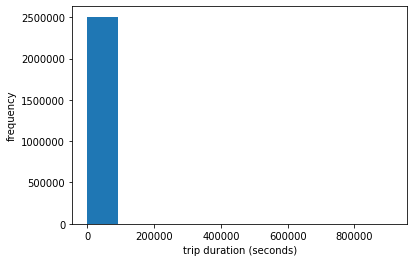

In [14]:
plt.hist(df.duration_sec)
plt.xlabel('trip duration (seconds)')
plt.ylabel('frequency')
plt.show()

The vast majority of trips had a duration shorter than 100,000 seconds (corresponding to approxiamtely 28 hours). Let's explore the trips that lasted longer than this. 

In [15]:
df[df.duration_sec > 100000]

duration_sec          start_time            end_time start_station_id  \
124395        912110 2019-12-19 23:15:36 2019-12-30 12:37:26              NaN   

       start_station_name  start_station_latitude  start_station_longitude  \
124395                NaN               37.323757              -121.878614   

       end_station_id end_station_name  end_station_latitude  \
124395            NaN              NaN             37.327656   

        end_station_longitude bike_id user_type     month   weekday  hour  \
124395            -121.868598  614329  Customer  December  Thursday    23   

        distance  
124395       986

There is a single trip that lasted about 10.5 days. This seems very unusual; we will remove this entry from the dataset. 

In [16]:
df = df.drop(124395, axis=0)

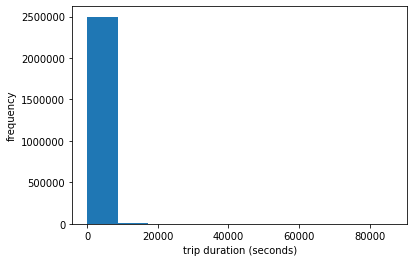

In [17]:
plt.hist(df.duration_sec)
plt.xlabel('trip duration (seconds)')
plt.ylabel('frequency')
plt.show()

The bulk of the trips are 10000 seconds or shorter. There is a strong right skew in the data. Let's log-transform this variable in order to deal with the wide range. 

In [18]:
df['duration_sec_log'] = np.log10(df.duration_sec)

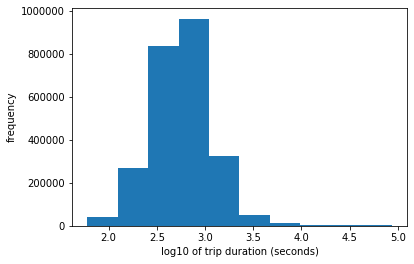

In [19]:
plt.hist(df.duration_sec_log)
plt.xlabel('log10 of trip duration (seconds)')
plt.ylabel('frequency')
plt.show()

Looks much better. Let's get more granularity by having smaller bin sizes. 

In [20]:
# let's find min and max to decide on range of the bins
min(df.duration_sec_log), max(df.duration_sec_log)

(1.7781512503836436, 4.935658386100634)

We will use a range from 1 to 5 and a step of 0.1 for the bins in the histogram. 

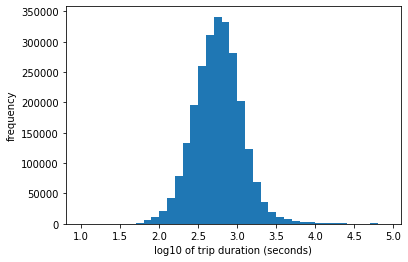

In [21]:
bin_edges = np.arange(1, 5, 0.1)

plt.hist(df.duration_sec_log, bins=bin_edges)
plt.xlabel('log10 of trip duration (seconds)')
plt.ylabel('frequency')
plt.show()


In [22]:
df.duration_sec_log.median()

2.756636108245848

In [23]:
# calculate the trip duration for
10**df.duration_sec_log.median()

571.0000000000001

Looks close to normally distributed. The median trip duration is 571 seconds (close to 10 minutes). 

### Month, week day, hour of day

Next, we will explore the timing of trips: month and week day and hour of day are qualitative ordinal data and will be explored with barplots. 

In [25]:
# let's choose one color for these barplots
blue = sb.color_palette()[0]

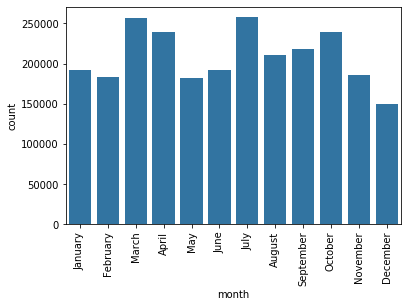

In [26]:
sb.countplot(x='month', data=df, color=blue)
plt.xticks(rotation=90);

There is quite a bit of variability of number of trips over the course of the year. Let's sort these to identify the months with the most and the fewest number of trips.

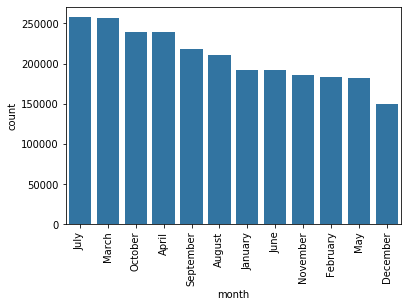

In [27]:
sb.countplot(data=df, x='month', color=blue, order=df.month.value_counts().index)
plt.xticks(rotation=90);

December had the fewest trips, which makes sense since it tends to be the coldest and rainiest month of the year in the bay area. July and March had the highest number of rides. 

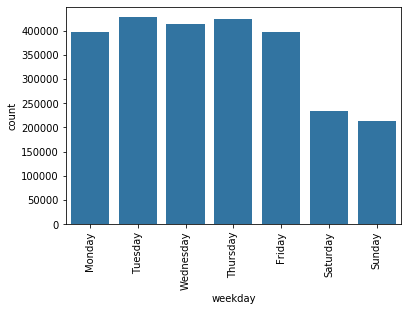

In [28]:
sb.countplot(x='weekday', data=df, color=blue)
plt.xticks(rotation=90);

Weekdays have similar number of rides per day (with Tuesday being the most popular day), in contrast bikes are much less used on Saturdays and Sundays. How about bike usages throughout the day?

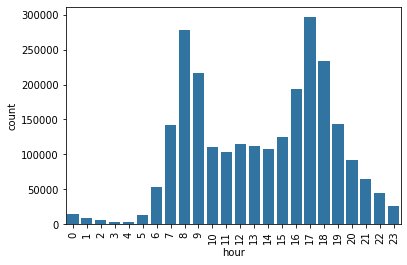

In [30]:
sb.countplot(x='hour', data=df, color=blue)
plt.xticks(rotation=90);

We observe a bimodal distribution with bikes being used most during peak morning (8 am) and evening (5 pm) rush hours. Very little use is observed during night between midnight and 5 am.  

### Trip distance

Next, we will explore the distance of trips: the corresponding variable is numerical and continuous. We will use a histogram to explore the variable. 

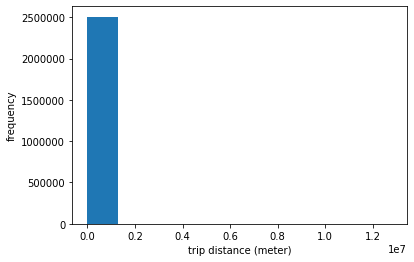

In [31]:
plt.hist(df.distance)
plt.xlabel('trip distance (meter)')
plt.ylabel('frequency')
plt.show()

There are some very rare long trips in the dataset. Let's explore a little more to find out about these. 

In [33]:
# extract some of the very long trips
df[df.distance > 100000]

duration_sec              start_time                end_time  \
1177            2365 2019-04-30 18:21:42.610 2019-04-30 19:01:08.146   
1943            1964 2019-04-30 17:31:19.646 2019-04-30 18:04:04.518   
2097             546 2019-04-30 17:45:38.452 2019-04-30 17:54:45.258   
2176             630 2019-04-30 17:39:33.507 2019-04-30 17:50:04.314   
2629             433 2019-04-30 17:17:10.486 2019-04-30 17:24:23.919   
...              ...                     ...                     ...   
101288          1032 2019-12-05 12:13:05.133 2019-12-05 12:30:17.370   
101952         47600 2019-12-04 20:50:17.859 2019-12-05 10:03:38.728   
121625         49921 2019-12-01 04:36:04.283 2019-12-01 18:28:05.886   
139590           157 2019-12-31 20:26:29.000 2019-12-31 20:29:07.000   
147154         58888 2019-12-31 00:28:31.000 2019-12-31 16:50:00.000   

       start_station_id                                start_station_name  \
1177                 50                             2nd St at Townsend St   
1943                 98                            Valencia St at 16th St   
2097                370                               Jones St at Post St   
2176                 21  Montgomery St BART Station (Market St at 2nd St)   
2629                 11                            Davis St at Jackson St   
...                 ...                                               ...   
101288              436                            McKinnon Ave at 3rd St   
101952                3      Powell St BART Station (Market St at 4th St)   
121625                5      Powell St BART Station (Market St at 5th St)   
139590              NaN                                               NaN   
147154              NaN                                               NaN   

        start_station_latitude  start_station_longitude end_station_id  \
1177                 37.780526              -122.390288            420   
1943                 37.765052              -122.421866            420   
2097                 37.787327              -122.413278            420   
2176                 37.789625              -122.400811            420   
2629                 37.797280              -122.398436            420   
...                        ...                      ...            ...   
101288               37.736296              -122.389970            449   
101952               37.786375              -122.404904            449   
121625               37.783899              -122.408445            449   
139590               37.766098              -122.396055            449   
147154               37.789489              -122.412138            449   

                     end_station_name  end_station_latitude  \
1177                  SF Test Station                   0.0   
1943                  SF Test Station                   0.0   
2097                  SF Test Station                   0.0   
2176                  SF Test Station                   0.0   
2629                  SF Test Station                   0.0   
...                               ...                   ...   
101288  16th Depot Bike Fleet Station                   0.0   
101952  16th Depot Bike Fleet Station                   0.0   
121625  16th Depot Bike Fleet Station                   0.0   
139590  16th Depot Bike Fleet Station                   0.0   
147154  16th Depot Bike Fleet Station                   0.0   

        end_station_longitude bike_id   user_type     month    weekday  hour  \
1177                      0.0    1612  Subscriber     April    Tuesday    18   
1943                      0.0    3507  Subscriber     April    Tuesday    17   
2097                      0.0    1142  Subscriber     April    Tuesday    17   
2176                      0.0    3500  Subscriber     April    Tuesday    17   
2629                      0.0    1181  Subscriber     April    Tuesday    17   
...                       ...     ...         ...       ...        ...   ...   
101288      

There is an issue with data quality: some latitudes and longitudes are set to 0.0 (which I'm assuming is the default value) while their corresponding start or end station have regular latitude and longitude entries. This creates very long distances. We'll clean this up by removing these rows from the dataframe. 

In [35]:
# remove entries where the longitude of start or end station equals 0
df.drop(df.distance[df.start_station_longitude == 0.0].index, axis=0, inplace=True)
df.drop(df.distance[df.end_station_longitude == 0.0].index, axis=0, inplace=True)

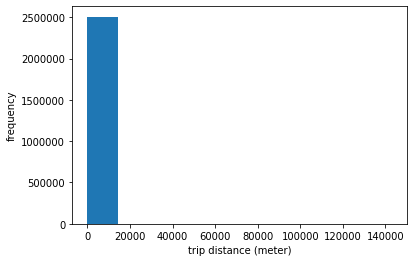

In [36]:
plt.hist(df.distance)
plt.xlabel('trip distance (meter)')
plt.ylabel('frequency')
plt.show()

The bulk of the trips were shorter than 10 km. There is a strong right skew in the data. Let's log-transform this variable in order to deal with the wide range. Some distances are 0 because the start and end station were identical. We'll first replace these 0s with NaN to avoid a conflict with log-transformation. 

In [38]:
# extract trips with a distance of 0 meters and confirm that start and end station are identical
df[df.distance == 0]

duration_sec              start_time                end_time  \
123             1473 2019-01-31 22:34:46.427 2019-01-31 22:59:20.357   
130              530 2019-01-31 22:49:05.546 2019-01-31 22:57:55.723   
148              788 2019-01-31 22:33:56.563 2019-01-31 22:47:05.335   
149              861 2019-01-31 22:32:10.430 2019-01-31 22:46:31.545   
151             3343 2019-01-31 21:48:56.564 2019-01-31 22:44:40.126   
...              ...                     ...                     ...   
149741          1567 2019-12-31 16:35:51.000 2019-12-31 17:01:59.000   
149748          3997 2019-12-29 17:02:41.000 2019-12-29 18:09:18.000   
149757          1186 2019-12-23 16:49:11.000 2019-12-23 17:08:58.000   
149770           785 2019-12-20 08:29:28.000 2019-12-20 08:42:33.000   
149860           403 2019-12-27 16:53:32.000 2019-12-27 17:00:15.000   

       start_station_id               start_station_name  \
123                 251  California St at University Ave   
130                 262        West St at University Ave   
148                 278           The Alameda at Bush St   
149                 196          Grand Ave at Perkins St   
151                 244       Shattuck Ave at Hearst Ave   
...                 ...                              ...   
149741                6    The Embarcadero at Sansome St   
149748                6    The Embarcadero at Sansome St   
149757                6    The Embarcadero at Sansome St   
149770                6    The Embarcadero at Sansome St   
149860              NaN                              NaN   

        start_station_latitude  start_station_longitude end_station_id  \
123                  37.870555              -122.279720            251   
130                  37.869967              -122.286533            262   
148                  37.331932              -121.904888            278   
149                  37.808894              -122.256460            196   
151                  37.873676              -122.268487            244   
...                        ...                      ...            ...   
149741               37.804770              -122.403234              6   
149748               37.804770              -122.403234              6   
149757               37.804770              -122.403234              6   
149770               37.804770              -122.403234              6   
149860               37.805320              -122.432322            NaN   

                       end_station_name  end_station_latitude  \
123     California St at University Ave             37.870555   
130           West St at University Ave             37.869967   
148              The Alameda at Bush St             37.331932   
149             Grand Ave at Perkins St             37.808894   
151          Shattuck Ave at Hearst Ave             37.873676   
...                                 ...                   ...   
149741    The Embarcadero at Sansome St             37.804770   
149748    The Embarcadero at Sansome St             37.804770   
149757    The Embarcadero at Sansome St             37.804770   
149770    The Embarcadero at Sansome St             37.804770   
149860                              NaN             37.805321   

        end_station_longitude bike_id   user_type     month   weekday  hour  \
123               -122.279720    4594  Subscriber   January  Thursday    22   
130               -122.286533    4551  Subscriber   January  Thursday    22   
148               -121.904888    3824  Subscriber   January  Thursday    22   
149               -122.256460    4526  Subscriber   January  Thursday    22   
151               -122.268487    1389    Customer   January  Thursday    21   
...                       ...     ...         ...       ...       ...   ...   
149741            -122.403234  882336  Subscriber  December   Tuesday    16   
149748            -122.403234  283991  Subscriber  December    Sunday    17   
149757            -122.403234  119878    

In [39]:
# replace 0 with NaN
df.distance.replace(0, np.nan, inplace=True)

In [40]:
# do the log-transformation and stor as a new column in the dataframe
df['distance_log'] = np.log10(df.distance)

In [41]:
df.distance_log.min(), df.distance_log.max()

(0.0, 5.155384627136393)

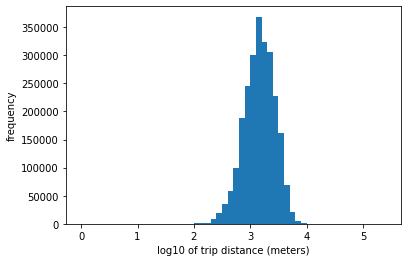

In [42]:
bin_edges = np.arange(0, 5.5, 0.1)

plt.hist(df.distance_log, bins=bin_edges)
plt.xlabel('log10 of trip distance (meters)')
plt.ylabel('frequency')
plt.show()

In [43]:
df.distance_log.median()

3.1720188094245563

In [44]:
# calculate the trip duration for
10**df.distance_log.median()

1485.9999999999993

Looks close to normally distributed. The median trip distance is 1486 meters (close to 1.5 km or 1 mile). 

### User type

Lastly, we will explore user type. This variable is of the categorical nominal type. We will plot the variable as a bar chart. 

In [46]:
df.user_type.value_counts()

Subscriber    2020373
Customer       485563
Name: user_type, dtype: int64

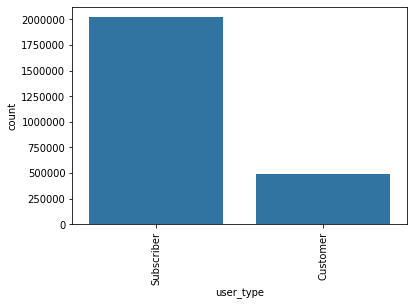

In [47]:
sb.countplot(x='user_type', data=df, color=blue)
plt.xticks(rotation=90);

It would be more informative to have percentages instead of total counts. Also, here the two bars should be colored differently, since they are categorical. 

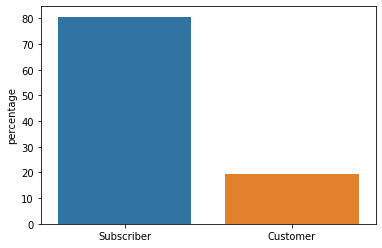

In [48]:
# transform counts into percentages
user_perc = df.user_type.value_counts() / df.shape[0] * 100

# create barplot
sb.barplot(data= df, x=user_perc.index, y=user_perc.values)
plt.ylabel('percentage')
plt.show()

There are 4 times more subscribers (\~80%) than non-subscribers (~20%). 

## Bivariate Exploration

Now, we next want to explore relationships between pairs of variables.

### Trip duration ~ trip distance

We'll start off with trip duration and trip distance. Since both are continuous numerical variables we will use a scatterplot. A scatterplot with > 2.5 million datapoints will take a long time to plot and is probably not that informative. We will therefore take a sample of 100,000 entries and plots these. 

In [49]:
# create a new dataframe with a subset of 100,000 of the original dataframe
df_sample = df.sample(n=100000)

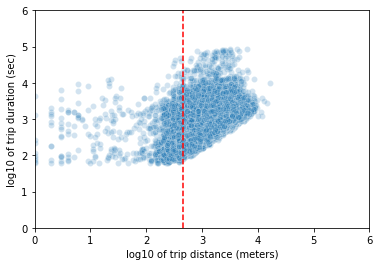

In [50]:
sb.scatterplot(data=df_sample , x='distance_log', y='duration_sec_log', alpha=0.2);
plt.xlim(0,6)
plt.ylim(0,6)
plt.xlabel('log10 of trip distance (meters)')
plt.ylabel('log10 of trip duration (sec)')
# add a line to signify the distance beyond which the minimum traveling duration steadily increases
plt.axvline(x=np.log10(450), color='red', ls='--')
plt.show()

Interestingly, up to a certain distance (approximately 450 meters, marked with the red dashed line) there is a wide spread in trip durations (between 100 and 10000 seconds). Beyond that the minimum time traveled increases with the distance, which makes sense as there is an upper limit for how fast a person can bike.

### Trip duration ~ weekday

Next, we will look at duration of trips on each weekday. We're dealing with a continuous numerical variable and a categorical variable and will therefore use violinplots. 

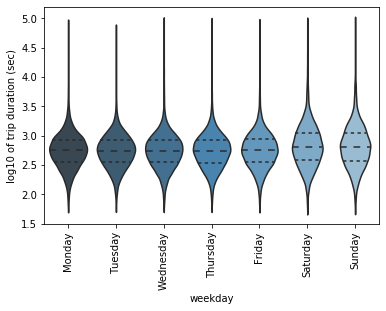

In [51]:
sb.violinplot(data = df_sample, x='weekday', y='duration_sec_log', inner='quartile', palette="Blues_d")
plt.xticks(rotation=90)
plt.ylabel('log10 of trip duration (sec)')
plt.show()

Trips on weekdends seem to be slightly longer than on weekdays. Let's have a closer look using non-log-transformed trip durations plotted as pointplots. 

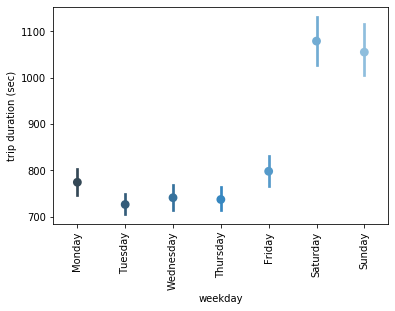

In [52]:
sb.pointplot(data=df_sample, x='weekday', y='duration_sec', palette="Blues_d")
plt.xticks(rotation=90)
plt.ylabel('trip duration (sec)')
plt.show()

People seem to be taking longer bike rides on the weekend: trip duration is about 200 second (~3.5 min) longer on Saturday and Sunday compared to weekdays. 

### Trip duration ~ month

Next, we will look at duration of trips in each month. Again, we have a continuous numerical variable and a categorical variable. We will use a boxenplots this time as a variation to violinplots in the previous example. 

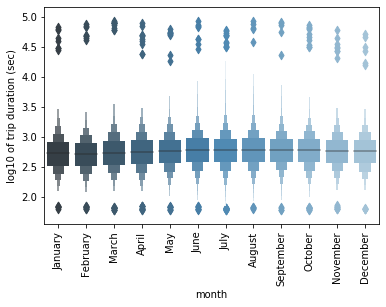

In [54]:
sb.boxenplot(data = df_sample, x='month', y='duration_sec_log', palette="Blues_d")
plt.xticks(rotation=90)
plt.ylabel('log10 of trip duration (sec)')
plt.show()

We observe a slight increase in trip duration during the summer months: June to August. 

### Trip duration ~ user type

Lastly, we will look at the relationship between user type (subscriber or non-subscriber) and trip duration. Let's use a violinplot again to explore this relationship. 

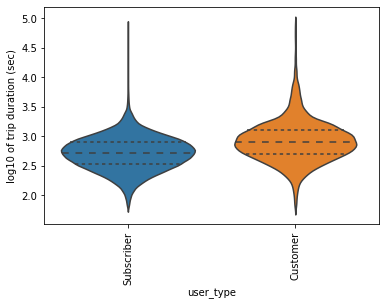

In [57]:
sb.violinplot(data = df_sample, x='user_type', y='duration_sec_log', inner='quartile')
plt.xticks(rotation=90)
plt.ylabel('log10 of trip duration (sec)')
plt.show()

Trips that non-subscribers do tend to be longer (on average about 10 min) than trips of subscribers. 

## Multivariate Exploration

### Trip duration ~ weekday and separated by user type

We want to know how trip duration for subscribers and non-subscribers changes over the course of the week. We will use clustered a bar chart and a pointplot for this. 

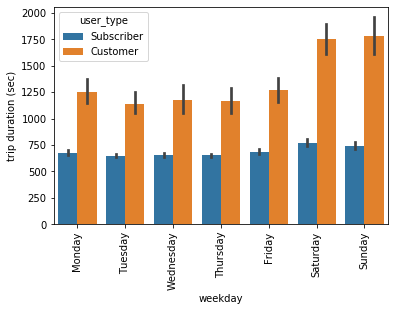

In [58]:
sb.barplot(data=df_sample, x='weekday', y='duration_sec', hue='user_type')
plt.xticks(rotation=90)
plt.ylabel('trip duration (sec)')
plt.show()

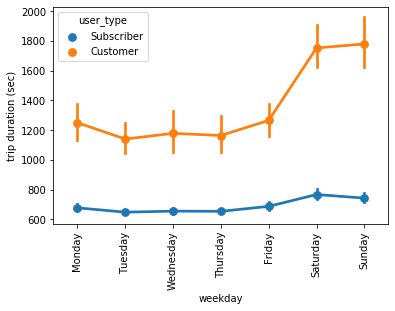

In [59]:
sb.pointplot(data=df_sample, x='weekday', y='duration_sec', hue='user_type')
plt.xticks(rotation=90)
plt.ylabel('trip duration (sec)')
plt.show()

Non-subscribers are taking longer trips than subscribers throughout the week. Both user types take longer trips on the weekends. The variability in trip duration appears to be higher for non-subscribers (indicated by the larger error bars) than for subscribers. 

### Number of trips per weekday per hour of day

We've seen before that number of trips fluctuate over the course of a day with peak usage at 8 am and 5 pm. We have also seen that bikes are used more frequently during the week than during weekends. Here we want to have a look at the combination of both variables weekday and hour of day in the context of number bike rides. Since both weekday and hour of day are categorical variables and number of bike rides is a continuous numerical variable we will plot this as a heatmap. 

In [60]:
# first count the trips per hour and weekday
counts = df_sample.groupby(['hour','weekday']).size()
counts = counts.reset_index(name='cnt')
counts = counts.pivot(index='weekday', columns='hour', values='cnt')

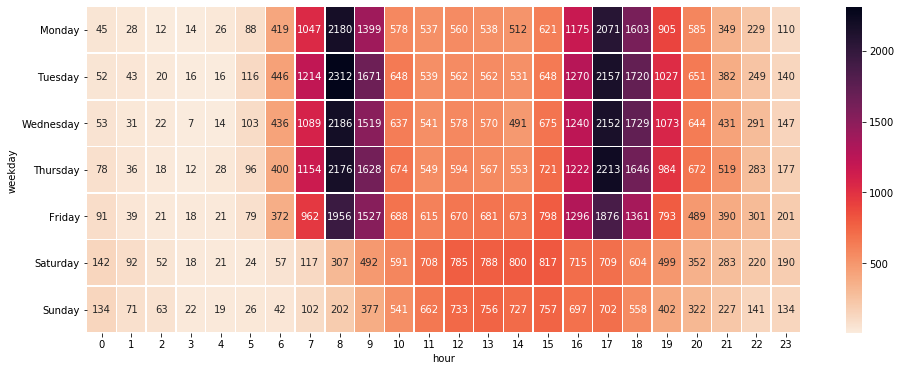

In [61]:
plt.figure(figsize=(16, 6))

sb.heatmap(counts, annot=True, fmt="d", linewidths=.5, cmap=sb.cm.rocket_r); 
plt.yticks(rotation=0)
plt.show()

During the week bike rides peak during morning and evening rush hour. In contrast, on the weekend days number of bike rides slowly increase starting at 9 am in the morning and peak in the early afternoon (1 and 2 pm). 

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!

In [62]:
# write final dataframe to file for explanatory exploration
df.to_csv('master_df.csv')